In [89]:
# import the necessary packages
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
import mahotas

# fixed-sizes for image
fixed_size = tuple((500, 500))
# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
#models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('image-classification/output/data.h5', 'r')
h5f_label = h5py.File('image-classification/output/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(global_features.shape))
print ("[STATUS] labels shape: {}".format(global_labels.shape))

print ("[STATUS] training started...")

[STATUS] features shape: (1360, 532)
[STATUS] labels shape: (1360,)
[STATUS] training started...


In [90]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=0.1)

print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print ("Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (1224, 532)
Test data   : (136, 532)
Train labels: (1224,)
Test labels : (136,)


['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lillyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']
0


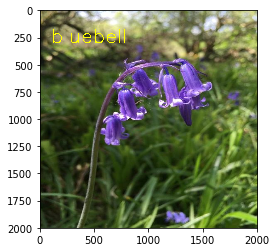

8


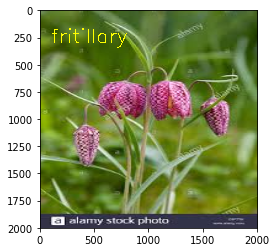

0


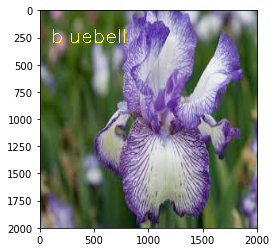

16


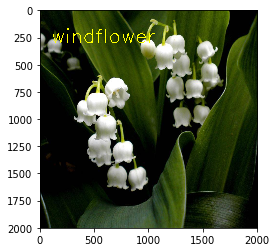

In [91]:
import matplotlib.pyplot as plt

# fixed-sizes for image
fixed_size = tuple((2000, 2000))

# path to training data
train_path = "image-classification/dataset/train_tp"

# no.of.trees for Random Forests
num_trees = 100

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()


# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# create the model - Random Forests
#clf  = SVC(random_state=9)

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100, random_state=9)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# path to test data
test_path = "image-classification/dataset/test_tp"



# loop through the test images

for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]
    print (prediction)
    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (100,300), cv2.FONT_HERSHEY_SIMPLEX, 6.0, (0,1500,1750), 8)
    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()